
# HyeongKyun Kim 21-732-797
# Songyi Han 18-796-847

*This assignment is done by **HyeongKyun Kim** and **SongYi Han** - We both **equally contributed** to this work by writing our own code individually first and then compare/merge them together.*


# A06: Inference of Networks

In [69]:
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt

from NEMtropy import UndirectedGraph, DirectedGraph
from NEMtropy.network_functions import build_adjacency_from_edgelist

import os
import re

In [70]:
g_WDN_dir = []
g_WDN_undir = []
names = []

for file in sorted(os.listdir("../Data")):
    if file.endswith(".graphml"):
        #print(file)
        g_dir= nx.read_graphml(os.path.join("../Data", file))
        g_undir = g_dir.to_undirected()
        g_WDN_dir.append(g_dir)
        g_WDN_undir.append(g_undir)
        names.append(re.findall(r'[0-9]+',file)[0])


# Function Definition

In [71]:
def get_avgclst_list(G_list, isWeight):

    g_avgclst=[]

    for g in G_list:
        avgclst = nx.average_clustering(g,weight = "weight" if isWeight else None)
        g_avgclst.append(avgclst)

    return g_avgclst

def get_recipr_list(G_list):

    g_recipr=[]

    for g in G_list:
        recipr = nx.reciprocity(g)
        g_recipr.append(recipr)
        
    return g_recipr

def get_strassr_list(G_list,isWeight):
    g_strassr=[]
    g_is_dir = nx.is_directed(G_list[0])
    for g in G_list:
        if g_is_dir:
            strassr1 = nx.degree_pearson_correlation_coefficient(g,'in','in', weight='weight' if isWeight else None)
            strassr2 = nx.degree_pearson_correlation_coefficient(g,'in','out', weight='weight' if isWeight else None)
            strassr3 = nx.degree_pearson_correlation_coefficient(g,'out','out', weight='weight' if isWeight else None)
            strassr = [strassr1,strassr2,strassr3]
        else:
            strassr = nx.degree_pearson_correlation_coefficient(g, weight='weight' if isWeight else None)
        #print(strassr)
        g_strassr.append(strassr)
        
    return g_strassr

In [72]:
def get_ERGM_fromGlist(g_list, sample, output_dir, isWeight, solveTool_maxStep=100):
    # 1. From the observed graph, prepare the adjacency matrix.
    adj_g_list = []
    solution_error = []
    i = 0
    g_is_dir = nx.is_directed(g_list[0])

    for g in g_list:
        # 1. From the observed graph, prepare the adjacency matrix.
        adj = nx.to_numpy_array(g, weight = "weight" if isWeight else None)

        # 2. For each adjacency matrix, Solve the maximum likelihood problem
        #    and save the 10 sample network at the desired output directory.
        #    solve model = Binary Directed Configuration Model (dcm_exp)
        graph = DirectedGraph(adj) if g_is_dir else UndirectedGraph(adj)

        if isWeight:
            graph.solve_tool(model="crema",
                            method="newton",
                            initial_guess="random",
                            #adjacency = adj_g
                            adjacency="dcm_exp" if g_is_dir else "cm_exp"
                            , method_adjacency="newton"
                            , max_steps = solveTool_maxStep)
        else:
            graph.solve_tool(model="dcm_exp" if g_is_dir else "cm_exp", max_steps = solveTool_maxStep)

        graph.ensemble_sampler(sample, cpu_n=1, output_dir=output_dir+str(i)+"/")       
        print("relative error strength is...", graph.relative_error_strength)
        i += 1


def get_ERGM_avgclst_list (g_list, directory, sample, isWeight):
    result = []
    g_is_dir = nx.is_directed(g_list[0])

    for f in range(len(g_list)):
        for i in range(sample):
            _ = []
            edgelist = np.loadtxt(directory + str(f) + "/" + str(i) + ".txt")            
            adj = build_adjacency_from_edgelist(edgelist = edgelist,
                                                is_directed = g_is_dir,
                                                is_sparse = False,
                                                is_weighted = isWeight)
            
            g = nx.from_numpy_array(adj,create_using = nx.DiGraph if g_is_dir else nx.Graph)
            #print(nx.is_weighted(g), nx.is_weighted(g))
            _.append(g)
        result.append(np.average(get_avgclst_list(_, isWeight)))
    return result

def get_ERGM_recipr_list (g_list, directory, sample, isWeight):
    result = []
    g_is_dir = nx.is_directed(g_list[0])

    for f in range(len(g_list)):
        for i in range(sample):
            _ = []
            edgelist = np.loadtxt(directory + str(f) + "/" + str(i) + ".txt")
            adj = build_adjacency_from_edgelist(edgelist = edgelist,
                                                is_directed = g_is_dir,
                                                is_sparse = False,
                                                is_weighted = isWeight)
            g = nx.from_numpy_array(adj,create_using = nx.DiGraph if g_is_dir else nx.Graph)
            _.append(g)
        result.append(np.average(get_recipr_list(_)))
    return result

def get_ERGM_strassr_list (g_list, directory, sample, isWeight):
    result = []
    g_is_dir = nx.is_directed(g_list[0])

    for f in range(len(g_list)):
        for i in range(sample):
            _ = []
            edgelist = np.loadtxt(directory + str(f) + "/" + str(i) + ".txt")
            adj = build_adjacency_from_edgelist(edgelist = edgelist,
                                                is_directed = g_is_dir,
                                                is_sparse = False,
                                                is_weighted = isWeight)
            g = nx.from_numpy_array(adj,create_using = nx.DiGraph if g_is_dir else nx.Graph)
            _.append(g)
        mean = np.average(get_strassr_list(_,isWeight), axis = 0)
        #print(mean)
        result.append(mean)
    return result



# A06.1 Exponential Random Graph Models


*Task: Task: For the World Trade Web dataset, it diferent ERGM-based Coniguration Models and compare basic network metrics with null models
.*

For each of the WTW networks provided:
+ measure the average clustering and reciprocity coefficients
+ fit the Undirected Binary CM and Directed Binary CM
+ sample 10 networks from the obtained distributions and measure clustering and reciprocity (for the Directed ones)
+ plot clustering and reciprocity as functions of time, comparing the real value with the average from the sampled networks


In [73]:
# 1. From the observed graph,
#    Measure the average clustering and reciprocity coefficients.
g_WDN_dir_avgclst = get_avgclst_list(g_WDN_dir, False)
g_WDN_dir_recipr = get_recipr_list(g_WDN_dir)
g_WDN_undir_avgclst = get_avgclst_list(g_WDN_undir, False)

# 2. Fit the Undirected Binary CM and Directed Binary CM
#    create the edge list text file of sample graph at the desired directory.
sample = 10
directory_dir = "../Data/sample_dir"
directory_undir = "../Data/sample_undir"

get_ERGM_fromGlist(g_WDN_dir, sample, directory_dir, False)
get_ERGM_fromGlist(g_WDN_undir, sample, directory_undir, False)

# 3. Claculate the sample graph's average network property
#    - the average clsutering coefficients
#    - the reciprocity coefficients
g_WDN_dir_ERGM_avgclst = get_ERGM_avgclst_list(g_WDN_dir, directory_dir, sample, False)
g_WDN_dir_ERGM_recipr = get_ERGM_recipr_list(g_WDN_dir, directory_dir, sample, False)
g_WDN_undir_ERGM_avgclst = get_ERGM_avgclst_list(g_WDN_undir, directory_undir, sample, False)




solution error = 2.1877468725506333e-09


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numba/core/utils.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


relative error strength is... None

solution error = 3.330004716417534e-09
relative error strength is... None

solution error = 2.416214783806936e-09
relative error strength is... None

solution error = 3.755349808898245e-09
relative error strength is... None

solution error = 1.5778809370203817e-09
relative error strength is... None

solution error = 1.8942500901175663e-09
relative error strength is... None

solution error = 3.840654017039924e-09
relative error strength is... None

solution error = 3.5947493870480685e-09
relative error strength is... None

solution error = 7.447397365467623e-09
relative error strength is... None

solution error = 3.089290601110406e-09
relative error strength is... None

solution error = 1.8124417522358272e-09
relative error strength is... None

solution error = 4.493529104365734e-09
relative error strength is... None

solution error = 6.527841378556332e-09
relative error strength is... None

solution error = 1.8455068584444234e-09
relative error stren

Text(0, 0.5, 'Average Clustering Coefficient')

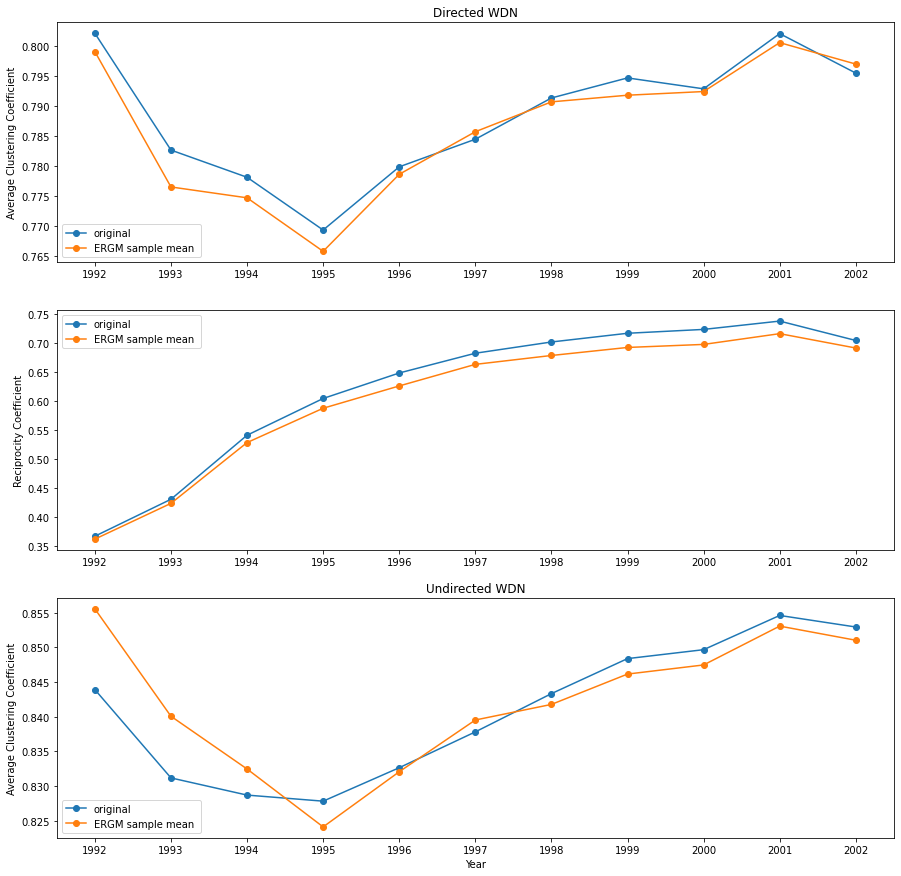

In [81]:
# 4. Plot Clustering Coefficient and Reciprocity comparing the real value with the sampled networks.
fig, axs = plt.subplots(3,1, figsize = (15,15))
axs[0].plot(names, g_WDN_dir_avgclst, marker = 'o', label = 'original')
axs[0].plot(names, g_WDN_dir_ERGM_avgclst, marker = 'o', label = 'ERGM sample mean ')
axs[0].legend()
axs[0].title.set_text('Directed WDN')
axs[0].set_ylabel('Average Clustering Coefficient')

axs[1].plot(names, g_WDN_dir_recipr, marker = 'o', label = 'original')
axs[1].plot(names, g_WDN_dir_ERGM_recipr, marker = 'o', label = 'ERGM sample mean ')
axs[1].legend()
axs[1].set_ylabel('Reciprocity Coefficient')

axs[2].plot(names, g_WDN_undir_avgclst, marker = 'o', label = 'original')
axs[2].plot(names, g_WDN_undir_ERGM_avgclst, marker = 'o', label = 'ERGM sample mean ')
axs[2].legend()
axs[2].title.set_text('Undirected WDN')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Average Clustering Coefficient')


# A06.2 Weighted ERGMs


*Task: Repeat the analysis of point 1 with weighted networks.*

+ measure strength assortativity coefficient on the data
+ fit the Undirected Enhanced CM and Directed Enhanced CM using the CReMa method
+ sample 10 networks from the obtained distributions and measure strength assortativity
+ plot strength assortativity as a function of time, comparing the real value with the average from the sampled networks in the directed case, plot all pairs of assortativity (in-in, in-out, out-out)



In [79]:
# 1. From the observed graph,
#    Measure the average clustering and reciprocity coefficients.
g_WDN_dir_strassr = get_strassr_list(g_WDN_dir, True)
g_WDN_undir_strassr = get_strassr_list(g_WDN_undir, True)

# 2. Fit the Undirected Binary CM and Directed Binary CM
#    create the edge list text file of sample graph at the desired directory.
sample = 10
directory_dir = "../Data/sample_dir_w"
directory_undir = "../Data/sample_undir_w"

get_ERGM_fromGlist(g_WDN_dir, sample, directory_dir, True, 2000)
get_ERGM_fromGlist(g_WDN_undir, sample, directory_undir, True, 2000)

# 3. Claculate the sample graph's average network property
#    - the average clsutering coefficients
#    - the reciprocity coefficients
g_WDN_dir_ERGM_strassr = get_ERGM_strassr_list(g_WDN_dir, directory_dir, sample, True)
g_WDN_undir_ERGM_strassr = get_ERGM_strassr_list(g_WDN_undir, directory_undir, sample, True)




solution error = 673547.7129652798
relative error strength is... 0.0030398265612064028

solution error = 122263.1937866211
relative error strength is... 1.0251343501669368e-05

solution error = 551929.5459594727
relative error strength is... 0.0013611989613227533

solution error = 113808.47528076172
relative error strength is... 2.518277927403815e-07

solution error = 293614.05364990234
relative error strength is... 6.767026533788028e-07

solution error = 138740.4871826172
relative error strength is... 0.001536836279657347

solution error = 239833.05615234375
relative error strength is... 0.00043645696337900943

solution error = 180757.12329101562
relative error strength is... 4.737511071925309e-05

solution error = 303656.52264404297
relative error strength is... 6.359401343342194e-07

solution error = 435945.7653808594
relative error strength is... 0.00011245142047598321

solution error = 211889.2344970703
relative error strength is... 9.756995315680628e-07

solution error = 49.0439

Text(0.5, 0, 'Year')

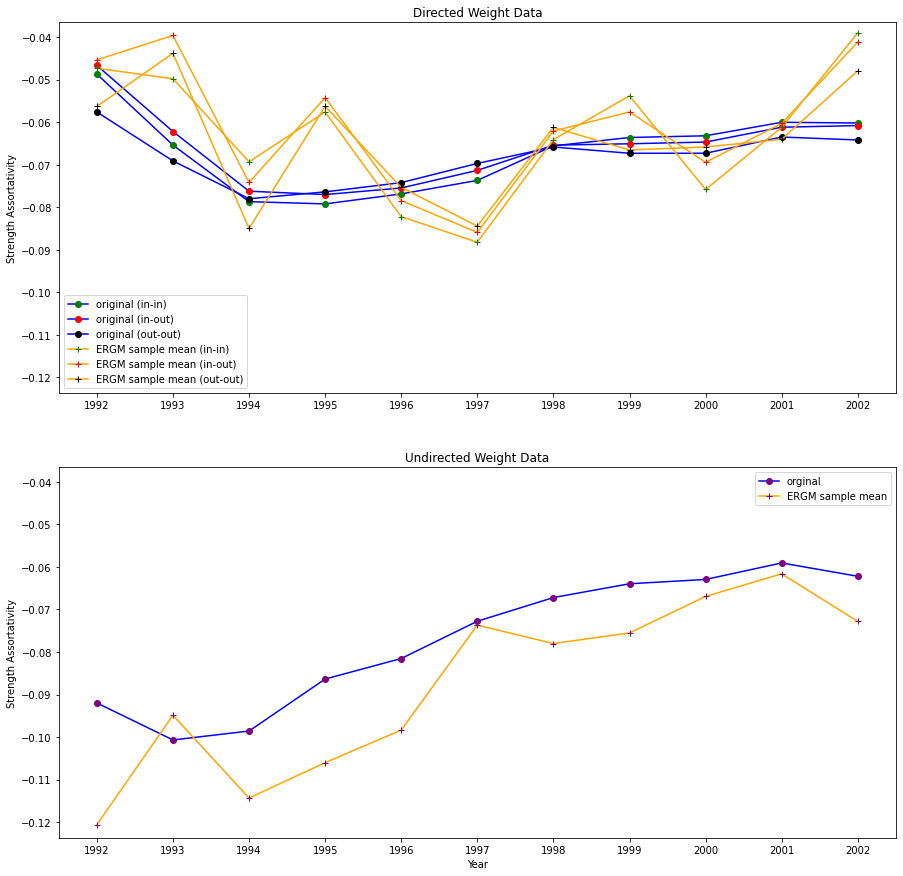

In [91]:
# 4. Plot Clustering Coefficient and Reciprocity comparing the real value with the sampled networks.
fig, axs = plt.subplots(2,1, figsize = (15,15))

axs[0].plot(names, list(np.array(g_WDN_dir_strassr)[:,0]), marker = 'o', label = 'original (in-in)', color = 'blue', mfc='green', mec = 'green')
axs[0].plot(names, list(np.array(g_WDN_dir_strassr)[:,1]), marker = 'o', label = 'original (in-out)',color = 'blue', mfc='red', mec = 'red')
axs[0].plot(names, list(np.array(g_WDN_dir_strassr)[:,2]), marker = 'o', label = 'original (out-out)',color = 'blue', mfc='black', mec = 'black')

axs[0].plot(names, list(np.array(g_WDN_dir_ERGM_strassr)[:,0]), marker = '+', label = 'ERGM sample mean (in-in)',color = 'orange', mfc='green', mec = 'green')
axs[0].plot(names, list(np.array(g_WDN_dir_ERGM_strassr)[:,1]), marker = '+', label = 'ERGM sample mean (in-out)',color = 'orange', mfc='red', mec = 'red')
axs[0].plot(names, list(np.array(g_WDN_dir_ERGM_strassr)[:,2]), marker = '+', label = 'ERGM sample mean (out-out)',color = 'orange', mfc='black', mec = 'black')

axs[1].plot(names, g_WDN_undir_strassr, marker = 'o', label = 'orginal',color = 'blue', mfc='purple', mec = 'purple')
axs[1].plot(names, g_WDN_undir_ERGM_strassr, marker = '+', label = 'ERGM sample mean',color = 'orange', mfc='purple', mec = 'purple')

bottom_0, top_0 = axs[0].set_ylim()
bottom_1, top_1 = axs[1].set_ylim()

bottom = min(bottom_0,bottom_1)
top = max(top_0,top_1)

axs[0].set_ylim(bottom,top)
axs[1].set_ylim(bottom,top)

axs[0].legend()
axs[1].legend()

axs[0].set_title('Directed Weight Data')
axs[1].set_title('Undirected Weight Data')

axs[0].set_ylabel('Strength Assortativity')
axs[1].set_ylabel('Strength Assortativity')

axs[1].set_xlabel('Year')




# A06.3 Drawing conclusions
*Task: write a short paragraph to draw conclusions about the structure of the World Trade Web based on the ERGM inferential approach.*

You should include at least the following points:

+ Comment on the interpretation of the clustering and reciprocity coefficients found in the original data

    Clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together whereas Reciprocity coefficent is a measure of the likelihood of vertices in a directed network to be mutually linked. From 1992 to 1995, there is a tendency that clustering coefficient decrease. Simply we can interprete neighbors of node were disconnected each other at this period. However, in same period, reciprocity coefficient increases which mean there were new mutual connections continuouly. With this two respect, we can infer that there was an emergence of giant node which has higher degree than other nodes. Then after 1995, both clustering coefficient and reciprocity coefficient increases which means many new trades among countries.

+ Comment on the interpretation of strength assortativity for this dataset

    Strengh assortativity coefficient measures the correlation between the characteristics of every pair of nodes that are connected. In directed graph, there are 4 types of assortativities and we plot in-in, in-out, and out-out. The value of three assortativities were similar and negative - which means it is dissortative. Similar to the tendency of clustering coefficient in previous task, strength assortativity decreases from 1992 to 1994 and then slowly increases till 2002. Since the strencgh assortativity is negative, decrease of value means node with large degree mostly connected to nodes with low degree. We can again conclude that there was a country which mainly traded with all other countries

+ Comment on the conclusions you can draw via the inference of the UBCM, DBCM and DECM models

    First of all, I’d like to look into the result of the clustering and reciprocity coefficient from 6-1. Both directed and undirected sample networks which are generated by the model with DBCM and UBCM each shows the nearly same values with the original data. Furthermore, those have a similar tendency like the original data set over time.

    Secondly, for 6-2, I used CReMa model for a faster implementation instead of DECM. But, the thing is that the result shows the same result with 6-1. It means that, even under the weighted network condition, the sample networks from the model with CReMa follow same value and tendency of assortativity with the original data.

    To sum up, we can create random network samples by using NEMtropy library which implement Maximum Entropy Network Model derived from ERGM family. Compared to other previous Random Network Generation approaches, this method use the sequence of degree or strength as a local constraints and Maximum-Entropy Principle to derive the model. So, we could find out the result of unbiased network properties from not only undirected and directed, but also weighted network. In other words, by using this ERGM, we were able to create various random network from the original data with various constraints.
